In [1]:
import pandas as pd
import pandas as pd
# 데이터 로드
dir = './data/'
files = ['오픈공격', '시간차공격', '이동공격', '후위공격', '속공', '퀵오픈']

# 데이터프레임을 저장할 리스트
dfs = []

for file in files:
    df = pd.read_csv(f'{dir}kovo_women_{file}.csv')
    df['공격유형'] = file  # ✅ 각 DataFrame에 공격유형 추가
    dfs.append(df)

# 수직 병합
df_total = pd.concat(dfs, ignore_index=True)

df_total

,순서,선수,포지션,전체팀,경기수,세트수,시도,성공,실패,범실,성공률,공격유형
0,1,모마,OP,현대건설,35,128,798,316,62,50,39.60,오픈공격
1,2,메가,OP,정관장,32,128,682,292,68,56,42.82,오픈공격
2,3,빅토리아,OP,IBK기업은행,36,135,767,272,55,75,35.46,오픈공격
3,4,부키리치,OH,정관장,30,119,704,271,51,70,38.49,오픈공격
4,5,실바,OP,GS칼텍스,32,124,580,224,64,66,38.62,오픈공격
...,...,...,...,...,...,...,...,...,...,...,...,...
175,26,김다은,OH,흥국생명,24,66,102,53,6,1,51.96,퀵오픈
176,27,고예림,OH,현대건설,34,91,141,52,5,9,36.88,퀵오픈
177,28,이예림,OH,페퍼저축은행,36,121,106,51,8,6,48.11,퀵오픈
178,29,마테이코,OP,흥국생명,8,30,83,40,3,3,48.19,퀵오픈


In [2]:
# 공격다양성(ADI) 산출을 위한 피벗테이블
pivot = pd.pivot_table(
    df_total,
    index='선수',                                # 행: 선수
    columns='공격유형',                          # 열: 공격 유형이 차원으로
    values=['세트수', '시도', '성공', '실패', '범실', '성공률'],  # 집계 대상
    aggfunc='sum',                               # 합계 기준
    fill_value=0
)

# 보기 좋게 컬럼 정리 (MultiIndex → 단일 컬럼명)
pivot.columns = [f'{val}_{col}' for val, col in pivot.columns]
pivot = pivot.reset_index()

In [3]:
# 공격다양성(ADI) 산출을 위한 피벗테이블
pivot = pd.pivot_table(
    df_total,
    index='선수',                                # 행: 선수
    columns='공격유형',                          # 열: 공격 유형이 차원으로
    values=['세트수', '시도', '성공', '실패', '범실', '성공률'],  # 집계 대상
    aggfunc='sum',                               # 합계 기준
    fill_value=0
)

# 보기 좋게 컬럼 정리 (MultiIndex → 단일 컬럼명)
pivot.columns = [f'{val}_{col}' for val, col in pivot.columns]
pivot = pivot.reset_index()
pivot

,선수,범실_속공,범실_시간차공격,범실_오픈공격,범실_이동공격,범실_퀵오픈,범실_후위공격,성공_속공,성공_시간차공격,성공_오픈공격,...,시도_오픈공격,시도_이동공격,시도_퀵오픈,시도_후위공격,실패_속공,실패_시간차공격,실패_오픈공격,실패_이동공격,실패_퀵오픈,실패_후위공격
0,강서우,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,강소휘,0,3,32,0,17,5,0,66,187,...,598,0,572,18,0,3,37,0,27,0
2,고예림,0,2,12,0,9,0,0,12,45,...,146,0,141,0,0,1,7,0,5,0
3,권민지,0,1,22,0,20,0,0,15,83,...,259,0,326,0,0,2,17,0,35,0
4,김다은,0,0,30,0,1,5,0,0,88,...,270,0,102,14,0,0,24,0,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,피치,9,0,0,26,0,0,54,0,0,...,0,304,0,0,11,0,0,18,0,0
71,하혜진,2,3,0,0,0,0,12,11,0,...,0,0,0,0,4,1,0,0,0,0
72,하효림,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73,황민경,0,1,14,0,18,0,0,11,74,...,292,0,318,2,0,0,18,0,17,1


In [4]:
import numpy as np
import pandas as pd

# 0) df 준비 (pivot을 쓰셨다면 df로 통일)
df = pivot.copy()

# 1) 컬럼 표준화: 공백 제거
df = df.copy()
df.columns = df.columns.str.replace(' ', '', regex=False)

# 2) '시도_'로 시작하는 공격유형별 시도 열 자동 탐색
attempt_cols = [c for c in df.columns if c.startswith('시도_')]
if len(attempt_cols) == 0:
    raise ValueError("시도_ 로 시작하는 열이 없습니다. 컬럼명을 확인하세요.")

# 3) 총 시도
df['총시도'] = df[attempt_cols].sum(axis=1)

# 4) 비율 p_i (총시도=0인 경우 0 처리)
probs = df[attempt_cols].div(df['총시도'].replace(0, np.nan), axis=0).fillna(0)

# 5) ADI = -Σ p_i * log2(p_i) (p_i=0은 무시)
probs_nonzero = probs.replace(0, np.nan)
df['ADI'] = -(probs_nonzero * np.log2(probs_nonzero)).sum(axis=1).fillna(0)

# 핕터링
df_adi  = df[['선수','ADI']]
df_adi

,선수,ADI
0,강서우,-0.000000
1,강소휘,1.448338
2,고예림,1.298976
3,권민지,1.213015
4,김다은,1.041601
...,...,...
70,피치,0.905928
71,하혜진,0.957181
72,하효림,-0.000000
73,황민경,1.284023


In [5]:
# AER, ER 지표 산출
df_women_attack = pd.read_csv('data/kovo_women_attack.csv')
# AER: 세트 수 대비 공격 시도 수
df_women_attack['AER'] = df_women_attack['시도'] / df_women_attack['세트수']
# ER : 공격 시도 수 대비 범실 수
df_women_attack['ER'] = df_women_attack['범실'] / df_women_attack['시도']
# 지표 필터링
df_AER_ER = df_women_attack[['선수','팀','AER','ER']]
# 병합
df3 = pd.merge(df_adi,df_AER_ER,how='inner',on='선수')

In [6]:
#AEI산출
df_woman_team = pd.read_csv('data/kovo_woman_team.csv')
df_woman_team = df_woman_team.rename(columns={'성공률':'팀_성공률'})

df_AEI = df_women_attack.merge(df_woman_team[['팀','팀_성공률']],how='left',on='팀')
df_AEI['AEI'] = df_AEI['성공률']/df_AEI['팀_성공률']
df_AEI = df_AEI[['선수','AEI']]
df_oidr = pd.merge(df3,df_AEI,on='선수',how='inner')
df_oidr

,선수,ADI,팀,AER,ER,AEI
0,강소휘,1.448338,한국도로공사,9.253521,0.043379,0.980105
1,권민지,1.213015,GS칼텍스,6.452632,0.070147,0.910627
2,김연경,1.582328,흥국생명,9.295082,0.070547,1.140486
3,니콜로바,1.576111,한국도로공사,9.641379,0.097282,1.031675
4,메가,1.674462,정관장,11.671875,0.082329,1.161711
5,모마,1.595796,현대건설,12.656250,0.060494,1.003924
6,박은서,1.536758,페퍼저축은행,5.971429,0.069378,1.023902
7,박정아,1.359540,페퍼저축은행,9.170370,0.051696,0.938299
8,배유나,1.814550,한국도로공사,4.457746,0.045814,1.058639
9,부키리치,1.540825,정관장,11.210084,0.106447,0.989364


In [7]:
from sklearn.preprocessing import StandardScaler
# 표준화 적용
ss = StandardScaler()
ss_df_oidr = ss.fit_transform(df_oidr.select_dtypes(include='number'))

# 지표 데이터셋 구축
df_oidr_ss = pd.DataFrame()
df_oidr_ss[['선수','팀']] = df_oidr[['선수','팀']]
df_oidr_ss[['ADI','AER','ER','AEI']] = ss_df_oidr
df_oidr_ss

,선수,팀,ADI,AER,ER,AEI
0,강소휘,한국도로공사,0.146791,0.470709,-1.195278,-0.392959
1,권민지,GS칼텍스,-0.754260,-0.313095,0.209699,-1.034125
2,김연경,흥국생명,0.659839,0.482340,0.230690,1.087103
3,니콜로바,한국도로공사,0.636034,0.579248,1.633948,0.082957
4,메가,정관장,1.012619,1.147464,0.849128,1.282983
5,모마,현대건설,0.711409,1.422933,-0.296963,-0.173141
6,박은서,페퍼저축은행,0.485352,-0.447755,0.169345,0.011222
7,박정아,페퍼저축은행,-0.193215,0.447440,-0.758724,-0.778759
8,배유나,한국도로공사,1.549015,-0.871346,-1.067492,0.331786
9,부키리치,정관장,0.500923,1.018236,2.114993,-0.307508


In [8]:
# OIDR 산출
df_oidr_ss['OCI'] = df_oidr_ss['ADI']*0.25 + df_oidr_ss['AEI'] *0.4 + df_oidr_ss['AER']*0.25 - df_oidr_ss['ER']*0.1
OCI = df_oidr_ss[['선수','팀','OCI']].sort_values(by='OCI',ascending=False).reset_index(drop=True)
OCI

,선수,팀,OCI
0,실바,GS칼텍스,1.258063
1,메가,정관장,0.968301
2,빅토리아,IBK기업은행,0.844048
3,테일러,페퍼저축은행,0.723841
4,김연경,흥국생명,0.697317
5,모마,현대건설,0.494026
6,배유나,한국도로공사,0.408881
7,이주아,IBK기업은행,0.394402
8,양효진,현대건설,0.388672
9,투트쿠,흥국생명,0.343319


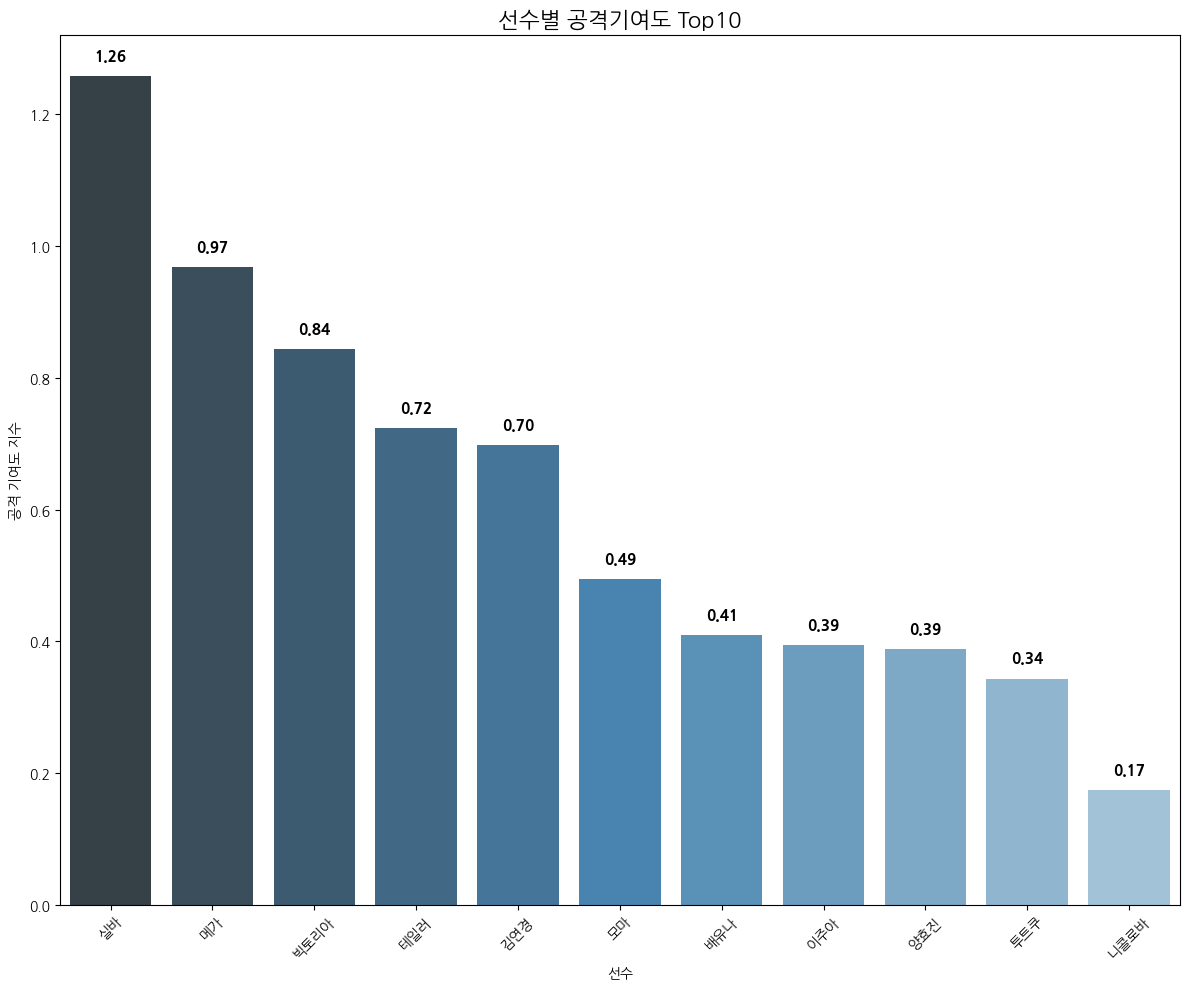

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

top10 = OCI.loc[:10, :]

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 10))
colors = sns.color_palette("Blues_d", len(top10))[::-1]
ax = sns.barplot(x='선수', y='OCI', data=top10, palette=colors)

# 각 막대 위에 라벨 표시
for i, row in enumerate(top10.itertuples()):
    plt.text(i, row.OCI + 0.02,        # y위치는 막대 위로 약간 띄움
             f"{row.OCI:.2f}",         # 소수점 둘째자리까지
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('선수별 공격기여도 Top10', fontsize=16)
plt.xlabel('선수')
plt.ylabel('공격 기여도 지수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('여자선수 공격기여도 파워랭킹.png')

In [10]:
team_count = top10['팀'].value_counts()
team_count

팀
IBK기업은행    2
흥국생명       2
현대건설       2
한국도로공사     2
GS칼텍스      1
정관장        1
페퍼저축은행     1
Name: count, dtype: int64

- 50%가 플레이오프 진출 못함

In [11]:
import plotly.graph_objects as go
from ipywidgets import interact

# 방사형차트 함수 정의
def radar_chart(player):
    row = df_oidr_ss[df_oidr_ss['선수'] == player].iloc[0]
    categories = ['ADI', 'AER', 'ER', 'AEI','OCI']
    values = [row[c] for c in categories]
    values += values[:1]  # 닫힌 형태 만들기

    fig = go.Figure(
        data=[go.Scatterpolar(r=values, theta=categories + [categories[0]],
                              fill='toself', name=player)],
        layout=go.Layout(title=f"{player}의 공격 영향 및 다양성 프로파일",
                         polar=dict(radialaxis=dict(visible=False, range=[-10, 10])))
    )
    fig.show()

# 동적 필터 (선수명 선택)
interact(radar_chart, player=df_oidr_ss['선수'].unique())

interactive(children=(Dropdown(description='player', options=('강소휘', '권민지', '김연경', '니콜로바', '메가', '모마', '박은서', …

<function __main__.radar_chart(player)>

In [12]:
df_oidr_ss.to_csv('여자부_지표.csv',encoding='utf-8',index=False)
#OIDR.to_csv('여자부_파워랭킹.csv',encoding='utf-8')

NameError: name 'OIDR' is not defined

In [13]:
df_oidr_ss

,선수,팀,ADI,AER,ER,AEI,OCI
0,강소휘,한국도로공사,0.146791,0.470709,-1.195278,-0.392959,0.116719
1,권민지,GS칼텍스,-0.754260,-0.313095,0.209699,-1.034125,-0.701458
2,김연경,흥국생명,0.659839,0.482340,0.230690,1.087103,0.697317
3,니콜로바,한국도로공사,0.636034,0.579248,1.633948,0.082957,0.173608
4,메가,정관장,1.012619,1.147464,0.849128,1.282983,0.968301
5,모마,현대건설,0.711409,1.422933,-0.296963,-0.173141,0.494026
6,박은서,페퍼저축은행,0.485352,-0.447755,0.169345,0.011222,-0.003046
7,박정아,페퍼저축은행,-0.193215,0.447440,-0.758724,-0.778759,-0.172075
8,배유나,한국도로공사,1.549015,-0.871346,-1.067492,0.331786,0.408881
9,부키리치,정관장,0.500923,1.018236,2.114993,-0.307508,0.045287
